<a href="https://colab.research.google.com/github/francesco-vaccari/ProjectDL/blob/fra/ProjectDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# per importare clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-koup17y6
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-koup17y6
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=76619d7cce8f5c3e88ef6f0ebb009f15939df90101acb93699208c6567cea5ad
  Stored in directory: /tmp/pip-ephem-wheel-cache-_uqqlpr3/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


# Dataset
Ho scoperto come scaricare il dataset tramite il link che ci hanno dato loro

In [1]:
!gdown 1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq

Downloading...
From: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq
To: /content/refcocog.tar.gz
100% 13.5G/13.5G [06:34<00:00, 34.1MB/s]


In [3]:
!tar -xf /content/refcocog.tar.gz

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import clip
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import json
from PIL import Image
from matplotlib import patches

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Utilizziamo il dataset RefCOCOg che contiene 25799 immagini con 3.7 espressioni per immagine. Nelle espressioni non ci sono location words.
Nella cartella annotations ci sono 2 files in formato pickle, noi dobbiamo utilizzare "ref(umd).p". Facciamo training sul train set ed evaluation sul test set.
Il dataset completo contiene 80000 istances (?) per training ma non per forza dobbiamo utilizzarle tutte, dobbiamo invece utilizzare tutto il test set.
Dobbiamo creare una custom dataset class per fare visual grounding.

link del dataset: https://drive.google.com/uc?id=1xijq32XfEm6FPhUb7RsZYWHc2UuwVkiq

La seguente è la classe per il custom dataset, sicuramente riesco a farla molto più efficiente però intanto c'è da far funzionare le cose correttamente

In [14]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, pickle_file, instances_file, type='train', transform=None):
        self.images_dir = images_dir
        self.transform = transform

        instances = json.load(open(instances_file, 'r'))
        pickle_file = pd.read_pickle(pickle_file)

        class Sentence:
            def __init__(self, tokens, raw, sent_id, sent):
                self.tokens = tokens
                self.raw = raw
                self.sent_id = sent_id
                self.sent = sent

        class PickleFile:
            def __init__(self, image_id, split, sentences, file_name, category_id, ann_id, sent_ids, ref_id):
                self.image_id = image_id
                self.split = split
                temp = []
                for elem in sentences:
                    temp.append(Sentence(elem['tokens'], elem['raw'], elem['sent_id'], elem['sent']))
                self.sentences = temp
                self.file_name = file_name
                self.category_id = category_id
                self.ann_id = ann_id # refers to id in class InstancesAnnotation
                self.sent_ids = sent_ids
                self.ref_id = ref_id # element index in pickle file

        class InstancesCategory:
            def __init__(self, supercategory, id, name):
                self.supercategory = supercategory
                self.id = id # from 1 to 90
                self.name = name

        class InstancesImage:
            def __init__(self, file_name, id, height, width):
                self.file_name = file_name
                self.id = id
                self.height = height
                self.width = width

        class InstancesAnnotation:
            def __init__(self, segmentation, area, iscrowd, image_id, bbox, category_id, id):
                self.segmentation = segmentation # list of lists
                self.area = area
                self.iscrowd = iscrowd
                self.image_id = image_id
                self.bbox = bbox
                self.category_id = category_id
                self.id = id

        instances_categories = dict()
        for elem in instances['categories']:
            instances_categories[elem['id']] = InstancesCategory(elem['supercategory'], elem['id'], elem['name'])

        instances_images = []
        for elem in instances['images']:
            instances_images.append(InstancesImage(elem['file_name'], elem['id'], elem['height'], elem['width']))

        instances_annotations = []
        for elem in instances['annotations']:
            instances_annotations.append(InstancesAnnotation(elem['segmentation'], elem['area'], elem['iscrowd'], 
                                                            elem['image_id'], elem['bbox'], elem['category_id'], 
                                                            elem['id']))

        informations = []
        for elem in pickle_file:
            informations.append(PickleFile(elem['image_id'], elem['split'], elem['sentences'], elem['file_name'], 
                                        elem['category_id'], elem['ann_id'], elem['sent_ids'], elem['ref_id']))

        class Annotation:
            def __init__(self, ann_id, segmentation, area, iscrowd, bbox, annot_category_id):
                self.ann_id = ann_id
                self.segmentation = segmentation
                self.area = area
                self.iscrowd = iscrowd
                self.bbox = bbox
                self.annot_category_id = annot_category_id
                self.split = None
                self.sentences = None
                self.info_file_name = None
                self.info_category_id = None
                self.info_ann_id = None

        class Information:
            def __init__(self, split, sentences, info_file_name, info_category_id, info_ann_id):
                self.split = split
                self.sentences = sentences
                self.info_file_name = info_file_name
                self.info_category_id = info_category_id
                self.info_ann_id = info_ann_id

        class ImageClass:
            def __init__(self, image_id, height, width, images_file_name):
                self.image_id = image_id
                self.height = height
                self.width = width
                self.images_file_name = images_file_name
                self.annotations = []
                self.informations = dict()

        images = dict() # key: image_id

        for elem in instances_images:
            images[elem.id] = ImageClass(elem.id, elem.height, elem.width, elem.file_name)

        for elem in informations:
            images[elem.image_id].informations[elem.ann_id] = Information(elem.split, elem.sentences, elem.file_name, elem.category_id, elem.ann_id)

        for elem in instances_annotations:
            images[elem.image_id].annotations.append(Annotation(elem.id, elem.segmentation, elem.area, elem.iscrowd, elem.bbox, elem.category_id))

        for key in images:
            ids = set()
            for info_key in images[key].informations:
                ids.add(info_key)
            for i, ann in enumerate(images[key].annotations):
                if ann.ann_id in ids:
                    images[key].annotations[i].split = images[key].informations[ann.ann_id].split
                    images[key].annotations[i].sentences = images[key].informations[ann.ann_id].sentences
                    images[key].annotations[i].info_file_name = images[key].informations[ann.ann_id].info_file_name
                    images[key].annotations[i].info_category_id = images[key].informations[ann.ann_id].info_category_id
                    images[key].annotations[i].info_ann_id = images[key].informations[ann.ann_id].info_ann_id

        class ANNPOV:
            def __init__(self, image_id, height, width, file_name, segmentation, area, iscrowd, bbox, category_id, split, sentences):
                self.image_id = image_id
                self.height = height
                self.width = width
                self.file_name = file_name
                self.segmentation = segmentation
                self.area = area
                self.iscrowd = iscrowd
                self.bbox = bbox
                self.category_id = category_id
                self.split = split
                self.sentences = sentences
            
            def stampa(self):
                print('------------------')
                print('image_id', self.image_id)
                print('height', self.height)
                print('width', self.width)
                print('file_name', self.file_name)
                print('segmentation', self.segmentation)
                print('area', self.area)
                print('iscrowd', self.iscrowd)
                print('bbox', self.bbox)
                print('cateogory_id', self.category_id)
                print('split', self.split)
                print('sentences')
                for sent in self.sentences:
                    print('\ttokens ', sent.tokens)
                    print('\traw ', sent.raw)
                    print('\tsent_id ', sent.sent_id)
                    print('\tsent ', sent.sent)
                print('------------------')

        data = []

        for id in images:
            for elem in images[id].annotations:
                if elem.split is not None:
                    data.append(ANNPOV(id, images[id].height, images[id].width, images[id].images_file_name, elem.segmentation, elem.area, elem.iscrowd, elem.bbox, elem.annot_category_id, elem.split, elem.sentences))
        
        self.spec_data = []
        for elem in data:
            if elem.split == type:
                self.spec_data.append(elem)
    
    def __len__(self):
        return len(self.spec_data)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.spec_data[idx].file_name)
        image = Image.open(image_path)
        
        if self.transform:
            image = self.transform(image)
        
        # don't know if there is preprocessing for the sentences too

        # since I cannot return an array of classes as sentences, i return an array of the attribute .sent of each element
        sentences = [] # has always length 10
        for sent in self.spec_data[idx].sentences:
            sentences.append(sent.sent)
        for i in range(len(sentences), 10):
            sentences.append('###')
        return (image, self.spec_data[idx].bbox, self.spec_data[idx].category_id, sentences)

Per creare i vari dataset ho messo che si passa il valore 'train' o 'val o 'test'. Chissà se le lunghezze dei dataset sono giuste

In [15]:
model, preprocess = clip.load("RN50", device=device)
model = model.to(device)


pickle_file = 'refcocog/annotations/refs(umd).p'
images_dir = 'refcocog/images/' # needs to have char '/' at the end
instances_file = 'refcocog/annotations/instances.json'


train_dataset = CustomDataset(images_dir, pickle_file, instances_file, type='train', transform=preprocess)
val_dataset = CustomDataset(images_dir, pickle_file, instances_file, type='val', transform=preprocess)
test_dataset = CustomDataset(images_dir, pickle_file, instances_file, type='test', transform=preprocess)

print('Train dataset len: ', len(train_dataset))
print('Val dataset len: ', len(val_dataset))
print('Test dataset len: ', len(test_dataset))

Train dataset len:  42224
Val dataset len:  2573
Test dataset len:  5023


Ed infine si può utilizzare il dataset come input per il dataloader anche se per il momento ci sono alcuni problemi con i bounding box che non vengono mostrati correttamente e con le sentences che si incasinano

Image shape:  torch.Size([3, 224, 224])
Bounding box:  tensor([186.6700,   0.0000,  21.9200, 333.3000], dtype=torch.float64)
Category id:  tensor(67)
N sentences:  4
	0)  a table top
	1)  a burger in the plate
	2)  light brown horse
	3)  a man holding a snowboard


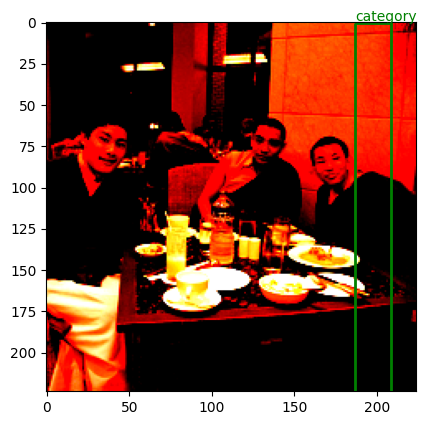

In [16]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

for idx, (image, bbox, category_id, sentences) in enumerate(train_loader):
    print('Image shape: ', image[idx].shape)
    print('Bounding box: ', bbox[idx])
    print('Category id: ', category_id[idx])
    print('N sentences: ', len(sentences[idx]))
    for i, sent in enumerate(sentences[idx]):
        print('\t' + str(i) + ')  ' + sent)

    fig, ax = plt.subplots()
    x, y, w, h = bbox[idx][0].item(), bbox[idx][1].item(), bbox[idx][2].item(), bbox[idx][3].item()
    bbox = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(bbox)
    ax.text(x, y-1, 'category', color='g')
    ax.imshow(image[0].permute(1, 2, 0))
    plt.show()
    break


# there are problems with the fact that since the image gets resized the bounding boxes are no longer correct
# I still need to add the category class so that i know to which class the category_id refers to
# there are problems with the __getitem__ method in the dataset which creates problems with the dataloader, the creation and return of sentences 
# is correct so the problem occurs later